# This file compares and analyses the IMBI_Marko miner

In [26]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 'C:/Users/Marko/Desktop/GIt/IMBI_Master')

In [27]:
from local_pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.log.importer.xes import importer as xes_importer
from local_pm4py.algo.analysis import custom_enum
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py import view_petri_net
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py import precision_alignments
from pm4py import precision_token_based_replay
from pm4py import discover_petri_net_heuristics
from pm4py.convert import convert_to_petri_net
from pm4py.algo.discovery.inductive import algorithm as pm4py_algorithm
from pm4py.algo.discovery.inductive.variants import imf as pm4py_imf
import pandas as pd
from pm4py.algo.discovery.inductive.algorithm import Variants as ind_Variants
from local_pm4py.algo.analysis import Optimzation_Goals
import matplotlib.pyplot as plt
import numpy as np
import math
import fpdf
from PIL import Image
import os

In [28]:
def f1_score(a, b):
  # try: catch
  if math.isclose(a+b,0):
    return 0
  return 2 * (a * b) / (a + b)

In [29]:
def visualize_cuts(fileName):
  pdf = fpdf.FPDF(format='letter') #pdf format
  pdf.add_page() #create new page
  pdf.set_font("Arial", size=8) # font and textsize

  depth = 0
  currentIteration = 1
  file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  
  folder_name = "imbi_cuts"
  # Check if the folder already exists
  if not os.path.exists(folder_name):
      # Create the folder
      os.makedirs(folder_name)
    
  # for depth
  while(os.path.isfile(file_path + ".png")):
    # for iteration
    while(os.path.isfile(file_path + ".png")):
      with open(file_path + ".txt") as f:
        pdf.cell(100, 4, txt="Cut: " + str(depth + 1) + " it: " + str(currentIteration), ln=1, align="C")
        pdf.cell(1000, 4, txt="cut | type | cost_p | cost_m | cost_ratio | fitP", ln=1, align="L")
        pdf.cell(1000, 4, txt="", ln=1, align="L")
        lines = f.readlines()
        readLines = 0
        for line in lines:
          if readLines == 0:
            outputLine = line.replace(" ", " | ")
          else:
            outputLine = line
          pdf.cell(1000, 4, txt=outputLine, ln=1, align="L")
          readLines += 1
          if readLines == 3:
            readLines = 0
            pdf.cell(1000, 4, txt="", ln=1, align="L")
      img = Image.open(file_path + ".png")
      width,height = img.size
      # print(width, height)
      pdf.image(file_path + ".png",w=min(150,width/3),h=min(150,height/3))
      pdf.add_page()
      currentIteration += 1
      file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
      
    depth += 1
    currentIteration = 1
    file_path = "imbi_cuts/depth_" + str(depth) + "_It_" + str(currentIteration)
  pdf.output(fileName + ".pdf")

In [30]:
def visualize_petriNet(df, miner, logPName, logMName = "", use_gnn = False):
  df_temp = df[df["miner"] == miner]
  df_temp = df_temp[df_temp["logM_Name"] == logMName]
  df_temp = df_temp[df_temp["logP_Name"] == logPName]
  df_temp = df_temp[df_temp["use_gnn"] == use_gnn]
  for net, im, fm, sup, ratio in zip(df_temp.net, df_temp.im, df_temp.fm, df_temp.im_bi_sup, df_temp.im_bi_ratio):
    print("Displaying: " + str(miner) + " " + str(logPName) + " " + str(logMName) + " Sup: " + str(sup) + " Ratio: " + str(ratio) + " GNN:" + str(use_gnn))
    view_petri_net(net, im, fm)

In [31]:
def visualize_All_petriNet(df, miner):
  df_temp = df[df["miner"] == miner]
  for logPName, logMName in zip(df_temp.logP_Name, df_temp.logM_Name):
    visualize_petriNet(df,miner,logPName,logMName)

In [32]:
def isRowPresent(df, miner, logPName, logMName, imf_noiseThreshold, hm_dependency_threshold, im_bi_sup, im_bi_ratio,pruning_threshold):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName]
  dftemp = dftemp[dftemp["logM_Name"] == logMName]
  dftemp = dftemp[dftemp["imf_noise_thr"] == imf_noiseThreshold]
  dftemp = dftemp[dftemp["hm_depen_thr"] == hm_dependency_threshold]
  dftemp = dftemp[dftemp["im_bi_sup"] == im_bi_sup]
  dftemp = dftemp[dftemp["im_bi_ratio"] == im_bi_ratio]
  dftemp = dftemp[dftemp["pruning_threshold"] == pruning_threshold]
  if len(dftemp.index) > 0:
    return True
  return False


In [33]:
def runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0, pruning_threshold = 0, use_gnn = False):
  mes = Optimzation_Goals.apply_petri(log,logM,net,im,fm)

  df = pd.concat([df, pd.DataFrame.from_records([{
    "miner" : name,
    "logP_Name": logPName[:logPName.rfind(".")],
    "logM_Name": logMName[:logMName.rfind(".")],
    "imf_noise_thr" : imf_noiseThreshold,
    "hm_depen_thr" : hm_dependency_threshold,
    "im_bi_sup" : im_bi_sup,
    "im_bi_ratio" : im_bi_ratio,
    "pruning_threshold" : pruning_threshold,
    "use_gnn" : use_gnn,
    "acc_logs": mes['acc'],
    "fitP" : mes['fitP'],
    "fitM" : mes['fitM'],
    "f1_fit_logs": mes['F1'],
    "precP" : mes['precision'],
    "net": net,
    "im" : im,
    "fm" : fm
  }])])
  return df

In [34]:
def runSingleLogEvaluation(df,log,logM, name, net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0, pruning_threshold = 0, use_gnn = False):
  
  # if isRowPresent(df, name, logPName, logMName, imf_noiseThreshold, hm_dependency_threshold, im_bi_sup, im_bi_ratio) == True:
  #   print ("Skipped because present")
  #   return df
  
  parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT:"pdf"}
  gviz = pn_visualizer.apply(net, im, fm, parameters=parameters)

  try:
    fitness_token = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)["log_fitness"]
  except:
    fitness_token = 0
  try:
    fitness_align = replay_fitness_evaluator.apply(log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)["log_fitness"]
  except:
    fitness_align = 0
    
  try:
    prec_token = precision_token_based_replay(log, net, im, fm)
  except:
    prec_token = 0
    
  try:
    prec_alignment = precision_alignments(log, net, im, fm)
  except:
    prec_alignment = 0
    

  df = pd.concat([df, pd.DataFrame.from_records([{
      "miner" : name,
      "logP_Name": logPName,
      "logM_Name": logMName,
      "imf_noise_thr" : imf_noiseThreshold,
      "hm_depen_thr" : hm_dependency_threshold,
      "im_bi_sup" : im_bi_sup,
      "im_bi_ratio" : im_bi_ratio,
      "pruning_threshold" : pruning_threshold,
      "use_gnn" : use_gnn,
      "fit_tok": fitness_token,
      "fit_alig": fitness_align,
      "prec_tok": prec_token,
      "prec_alig": prec_alignment,
      "f1_tok": f1_score(fitness_token, prec_token),
      "f1_alig": f1_score(fitness_align, prec_alignment),
      "net": net,
      "im" : im,
      "fm" : fm
  }])])
  return df

In [35]:
def add_Model_To_Database(df,log,logM, name,net, im, fm, logPName = "",logMName = "", imf_noiseThreshold = 0, hm_dependency_threshold = 0,im_bi_sup = 0, im_bi_ratio = 0, pruning_threshold = 0, use_gnn = False):
  if logMName == "":
    df = runSingleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio, pruning_threshold, use_gnn = use_gnn)
  else:
    df = runDoubleLogEvaluation(df,log,logM, name,net, im, fm, logPName,logMName, imf_noiseThreshold, hm_dependency_threshold,im_bi_sup, im_bi_ratio, pruning_threshold, use_gnn=use_gnn)
  return df

In [36]:
def getF1Value(df, miner, logPName, logMName, support, ratio, pruning_threshold, use_gnn):
  dftemp = df[df["miner"] == miner]
  dftemp = dftemp[dftemp["logP_Name"] == logPName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["logM_Name"] == logMName[:logPName.rfind(".")]]
  dftemp = dftemp[dftemp["im_bi_sup"] == support]
  dftemp = dftemp[dftemp["im_bi_ratio"] == ratio]
  dftemp = dftemp[dftemp["pruning_threshold"] == pruning_threshold]
  dftemp = dftemp[dftemp["use_gnn"] == use_gnn]
  if len(dftemp.index) > 1:
    raise Exception("Error, too many rows.")
  return dftemp["f1_fit_logs"].iloc[0]


In [37]:
def applyMinerToLog(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0, pruning_threshold = 0, use_gnn = False):
  logP = xes_importer.apply(logPathP)
  if logMName == "":
    logM = logP
    # inductive miner
    print("Running IM")
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IM)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IM",logPName=logPName, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
    
    #imf 
    print("Running IMF")
    parameters = {pm4py_imf.IMFParameters.NOISE_THRESHOLD : noiseThreshold}
    pt = pm4py_algorithm.apply(logP,variant=ind_Variants.IMf, parameters=parameters)
    net, im, fm = convert_to_petri_net(pt)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMF",logPName=logPName,imf_noiseThreshold=noiseThreshold, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
    
    #hm
    print("Running HM")
    net, im, fm = discover_petri_net_heuristics(logP,dependency_threshold=dependency_threshold)
    df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="HM",logPName=logPName,hm_dependency_threshold=dependency_threshold, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
  else:
    logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, pruning_threshold = pruning_threshold, size_par=len(logP)/len(logM), cost_Variant=cost_Variant,use_gnn=use_gnn)
  df = add_Model_To_Database(df=df,log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
  
  fileName_cuts_ali = "cuts_IMbi_ali_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP_" + logPName[:logPName.rfind(".")] + "_logM_" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_ali)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  #imbi_mar
  print("Running IMbi_mar")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_RELATION_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, pruning_threshold = pruning_threshold, size_par=len(logP)/len(logM), cost_Variant=cost_Variant,use_gnn=use_gnn)
  df = add_Model_To_Database(df=df, log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_mar",logPName=logPName, logMName=logMName, im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
  
  fileName_cuts_mar = "cuts_IMbi_mar_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP-" + logPName[:logPName.rfind(".")] + "_logM-" + logMName[:logMName.rfind(".")]
  visualize_cuts(fileName_cuts_mar)
  
  for f in os.listdir("imbi_cuts"):
    os.remove(os.path.join("imbi_cuts", f))
  
  # for double log
  marImproved = False
  if logMName != "":
    f1_ali = getF1Value(df,"IMbi_ali",logPName,logMName,support,ratio, pruning_threshold, use_gnn = use_gnn)
    f1_mar = getF1Value(df,"IMbi_mar",logPName,logMName,support,ratio, pruning_threshold, use_gnn = use_gnn)
    if f1_ali < f1_mar:
      display("Mar > Ali")
      marImproved = True
      if True:
        if os.path.exists(fileName_cuts_ali+ ".pdf"):
          os.remove(fileName_cuts_ali+ ".pdf")
        if os.path.exists(fileName_cuts_mar+ ".pdf"):
          os.remove(fileName_cuts_mar + ".pdf")
    else:
      display("Ali > Mar")
  return df, marImproved

In [38]:
def applyMinerToLogForGNN(df, logPathP, logPathM,logPName, logMName = "", noiseThreshold = 0.0, dependency_threshold=0.0, support = 0, ratio = 0, pruning_threshold = 0, use_gnn = False):
  logP = xes_importer.apply(logPathP)
  logM = xes_importer.apply(logPathM)
    
  # imbi_ali
  print("Running IMbi_ali")
  cost_Variant = custom_enum.Cost_Variant.ACTIVITY_FREQUENCY_SCORE
  net, im, fm = inductive_miner.apply_bi(logP,logM, variant=inductive_miner.Variants.IMbi, sup=support, ratio=ratio, pruning_threshold = pruning_threshold, size_par=len(logP)/len(logM), cost_Variant=cost_Variant,use_gnn=use_gnn)
  df = add_Model_To_Database(df=df,log=logP, logM=logM,net=net,im=im,fm=fm,name="IMbi_ali",logPName=logPName, logMName=logMName,im_bi_sup=support,im_bi_ratio=ratio,pruning_threshold = pruning_threshold, use_gnn = use_gnn)
  
  save_cuts = False
  if save_cuts == True:
    fileName_cuts_ali = "cuts_IMbi_ali_sup_" + str(support) + "_ratio_" + str(ratio) + "_logP_" + logPName[:logPName.rfind(".")] + "_logM_" + logMName[:logMName.rfind(".")]
    visualize_cuts(fileName_cuts_ali)
  
  return df

In [39]:
columns = ["miner", "logP_Name", "logM_Name","imf_noise_thr","hm_depen_thr","im_bi_sup","im_bi_ratio", "pruning_threshold", "use_gnn", "fit_tok", "fit_alig", "prec_tok", "prec_alig", "f1_tok", "f1_alig", "net", "im", "fm"]
df = pd.DataFrame(data=None, index=None, columns=columns, dtype=None, copy=None)
df['use_gnn'] = df['use_gnn'].astype(bool)

In [40]:
rootPath = "C:/Users/Marko/Desktop/IMbi_Data/analysing/"

lpNames = ["lp_2012.xes", "lp_2017.xes", "lp_2018.xes"]
# lpNames = ["lp_2012.xes"]

lMNames = ["lm_2012.xes", "lm_2017.xes", "lm_2018.xes"]
# lMNames = ["lm_2012.xes"]
lpPaths = []
lmPaths = []

for lp in lpNames:
  lpPaths.append((lp,rootPath + lp))
for lm in lMNames:
  lmPaths.append((lm,rootPath + lm))
  

In [41]:
runSingleLog = False
analyse_gnn = True

In [42]:
ratios = [0]
sups = [0.2, 0.4]
pruning_thresholds = [0, 0.1, 0.2]
runs = 1

totalRuns = len(lpPaths) * len(ratios) * len(sups) * len(pruning_thresholds)
if runSingleLog:
  if analyse_gnn == False:
    for i in range(0,len(lpPaths)):
      for ratio in ratios:
        for sup in sups:
          for pruning_threshold in pruning_thresholds:
            display("Running: " + lpPaths[i][0] + " " + str(runs) + "/" + str(totalRuns))
            display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup) + " pruning: " + str(pruning_threshold))
            df, marImproved = applyMinerToLog(df, lpPaths[i][1], "", lpPaths[i][0],"", 0.2, 0.99, sup, ratio, pruning_threshold)
            runs += 1

In [43]:
if runSingleLog == False:
  if analyse_gnn == False:
    runs = 1
    improving_runs = 0
    
    ratios = [1, 0.8]
    sups = [0.2, 0.3]
    pruning_thresholds = [0]
    
    totalRuns = len(lpPaths) * len(ratios) * len(sups) * len(pruning_thresholds)

    for i in range(0,len(lpPaths)):
      for ratio in ratios:
        for sup in sups:
          for pruning_threshold in pruning_thresholds:
            display("Running: " + lpPaths[i][0] + " " + str(runs) + "/" + str(totalRuns))
            display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup) + " pruning: " + str(pruning_threshold))
            display("Stats: " + str(improving_runs) + "/" + str(runs))
            df, marImproved = applyMinerToLog(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio, pruning_threshold)
            if marImproved:
              improving_runs += 1
            runs += 1
    
# display(df)

In [44]:
if analyse_gnn == True:
  runs = 1
  
  ratios = [1, 0.8]
  sups = [0.2, 0.3]
  using_gnn = [False, True]
  pruning_thresholds = [0]
  
  totalRuns = len(lpPaths) * len(ratios) * len(sups) * len(pruning_thresholds) * len(using_gnn)

  for i in range(0,len(lpPaths)):
    for ratio in ratios:
      for sup in sups:
        for pruning_threshold in pruning_thresholds:
          for use_gnn in using_gnn:
            display("Running: " + lpPaths[i][0] + " " + str(runs) + "/" + str(totalRuns))
            display("i: " + str(i) + " ratio: " + str(ratio) + " sup: " + str(sup) + " pruning: " + str(pruning_threshold))
            df = applyMinerToLogForGNN(df, lpPaths[i][1], lmPaths[i][1], lpPaths[i][0],lmPaths[i][0], 0.2, 0.99, sup, ratio, pruning_threshold,use_gnn)
            runs += 1
    

'Running: lp_2012.xes 1/24'

'i: 0 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 1734.13it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 349.65it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 1116.85it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 252.58it/s]


'Running: lp_2012.xes 2/24'

'i: 0 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2603.09it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 289.01it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 569.56it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 228.44it/s]


'Running: lp_2012.xes 3/24'

'i: 0 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2656.10it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 271.73it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 945.09it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 189.56it/s]


'Running: lp_2012.xes 4/24'

'i: 0 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2119.12it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 303.03it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 811.31it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 242.57it/s]


'Running: lp_2012.xes 5/24'

'i: 0 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2182.18it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 294.12it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 781.83it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 228.97it/s]


'Running: lp_2012.xes 6/24'

'i: 0 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2334.01it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 129.87it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 934.77it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 126.62it/s]


'Running: lp_2012.xes 7/24'

'i: 0 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2266.38it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 289.02it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 924.69it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:00<00:00, 221.22it/s]


'Running: lp_2012.xes 8/24'

'i: 0 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 587/587 [00:00<00:00, 2371.72it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 25/25 [00:00<00:00, 47.89it/s]
computing precision with alignments, completed variants :: 100%|██████████| 43/43 [00:00<00:00, 735.05it/s]
aligning log, completed variants :: 100%|██████████| 49/49 [00:01<00:00, 30.43it/s]


'Running: lp_2017.xes 9/24'

'i: 1 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1375.20it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:10<00:00, 41.45it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 513.49it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 151.15it/s]


'Running: lp_2017.xes 10/24'

'i: 1 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1378.04it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 14, model: 12


aligning log, completed variants :: 100%|██████████| 446/446 [00:02<00:00, 149.49it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 453.22it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 175.59it/s]


'Running: lp_2017.xes 11/24'

'i: 1 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1438.50it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:10<00:00, 40.82it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 535.39it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 133.01it/s]


'Running: lp_2017.xes 12/24'

'i: 1 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1244.30it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 14, model: 12


aligning log, completed variants :: 100%|██████████| 446/446 [00:12<00:00, 36.48it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 526.80it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:04<00:00, 17.31it/s]


'Running: lp_2017.xes 13/24'

'i: 1 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1668.99it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:06<00:00, 69.57it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 422.78it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:01<00:00, 74.31it/s] 


'Running: lp_2017.xes 14/24'

'i: 1 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1248.18it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 14, model: 12


aligning log, completed variants :: 100%|██████████| 446/446 [00:05<00:00, 81.19it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:03<00:00, 390.55it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:01<00:00, 47.81it/s] 


'Running: lp_2017.xes 15/24'

'i: 1 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:02<00:00, 1314.52it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 446/446 [00:11<00:00, 37.31it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:01<00:00, 722.72it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:00<00:00, 114.93it/s]


'Running: lp_2017.xes 16/24'

'i: 1 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 1629.99it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 14, model: 12


aligning log, completed variants :: 100%|██████████| 446/446 [00:07<00:00, 58.07it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1199/1199 [00:02<00:00, 447.05it/s]
aligning log, completed variants :: 100%|██████████| 82/82 [00:01<00:00, 49.01it/s] 


'Running: lp_2018.xes 17/24'

'i: 2 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2567.39it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 86.82it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:03<00:00, 352.14it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 89.90it/s]


'Running: lp_2018.xes 18/24'

'i: 2 ratio: 1 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2282.24it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 13, model: 12


aligning log, completed variants :: 100%|██████████| 197/197 [00:05<00:00, 33.63it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 226.86it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:03<00:00, 35.85it/s]


'Running: lp_2018.xes 19/24'

'i: 2 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2155.17it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 85.47it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 573.03it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 86.30it/s] 


'Running: lp_2018.xes 20/24'

'i: 2 ratio: 1 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2018.84it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 13, model: 12


aligning log, completed variants :: 100%|██████████| 197/197 [00:03<00:00, 62.64it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 561.15it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 80.64it/s]


'Running: lp_2018.xes 21/24'

'i: 2 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2283.11it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 72.88it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:03<00:00, 377.62it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 99.13it/s] 


'Running: lp_2018.xes 22/24'

'i: 2 ratio: 0.8 sup: 0.2 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2270.15it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 13, model: 12


aligning log, completed variants :: 100%|██████████| 197/197 [00:05<00:00, 35.43it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:05<00:00, 248.36it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:03<00:00, 43.72it/s]


'Running: lp_2018.xes 23/24'

'i: 2 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2567.40it/s]


Running IMbi_ali


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 85.65it/s] 
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 507.56it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 88.93it/s]


'Running: lp_2018.xes 24/24'

'i: 2 ratio: 0.8 sup: 0.3 pruning: 0'

parsing log, completed traces :: 100%|██████████| 3000/3000 [00:01<00:00, 2332.82it/s]


Running IMbi_ali
Error: the number of nodes in the genrated dataset is bigger then the number of nodes in the model. Dataset: 13, model: 12


aligning log, completed variants :: 100%|██████████| 197/197 [00:02<00:00, 65.95it/s]
computing precision with alignments, completed variants :: 100%|██████████| 1326/1326 [00:02<00:00, 543.00it/s]
aligning log, completed variants :: 100%|██████████| 137/137 [00:01<00:00, 82.98it/s]


In [45]:

def setupYTickList(minValue, step):
  res = []
  cur = 1
  while cur > minValue:
    res.append(cur)
    cur -= step
  res.append(cur)
  return res
    

def displayDoubleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "im_bi_ratio", "pruning_threshold"], group_keys=True).apply(lambda x : x)
  numberOfPlotPerRow = 4
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)

  fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
  fig.tight_layout(pad=10.0)
  cur_Row = 0
  cur_Col = 0
  
  for logGroup in df_grouped.index.unique():
    df_log_grouped = df_grouped.loc[logGroup]

    axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " ratio: " + str(df_log_grouped.im_bi_ratio[0]) + " Pruning: " + str(df_log_grouped.pruning_threshold[0]))
    axs[cur_Row,cur_Col].set_xlabel("Miners")
    j = 0
    xTickLabel = []
    idx = []
    minValue = 0
    for miner, use_gnn, acc, fitP, fitM, f1_fit in zip(df_log_grouped.miner, df_log_grouped.use_gnn, df_log_grouped.acc_logs, df_log_grouped.fitP, df_log_grouped.fitM, df_log_grouped.f1_fit_logs):
      minValue = min([minValue, acc, fitP, fitM, f1_fit])
      axs[cur_Row,cur_Col].bar(j,acc, color="r", label="acc")
      axs[cur_Row,cur_Col].bar(j+1,fitP, color="g", label="fitP")
      axs[cur_Row,cur_Col].bar(j+2,fitM, color="b", label="fitM")
      axs[cur_Row,cur_Col].bar(j+3,f1_fit, color="orange", label="f1_fit")
      xTickLabel.append(miner + "\nGNN: " + str(use_gnn))
      idx.append(j + 1.5)
      j += 5
      
    
    axs[cur_Row,cur_Col].set_yticks(setupYTickList(minValue, 0.25))
    axs[cur_Row,cur_Col].set_xticks(idx)
    axs[cur_Row,cur_Col].set_xticklabels(xTickLabel)
    axs[cur_Row,cur_Col].legend(loc='center left', ncols=1, labels=["acc", "fitP", "fitM", "f1_fit"], bbox_to_anchor=(1, 0.5))
    cur_Col += 1
    
    if cur_Col == numberOfPlotPerRow:
      cur_Row += 1
      cur_Col = 0
  
  plt.show()

  if saveFig:
    fig.savefig("plot" + ".pdf")

In [46]:
def displaySingleLog(df, saveFig = False):
  df_grouped = df.groupby(by=["logP_Name",	"logM_Name", "im_bi_sup", "pruning_threshold", "use_gnn"], group_keys=True).apply(lambda x : x)

  numberOfPlotPerRow = 3
  rows = math.ceil(float(len(df_grouped.index.unique()))/numberOfPlotPerRow)
  cols = min(len(df_grouped.index.unique()),numberOfPlotPerRow)
  
  f1_measures = ["f1_tok", "f1_alig"]
  f1_measures = ["f1_alig"]
  
  for f1_measure in f1_measures:
    fig, axs = plt.subplots(rows, cols, figsize=(15 * (cols / numberOfPlotPerRow), 4 * rows), squeeze=False)
    fig.tight_layout(pad=10.0)
    cur_Row = 0
    cur_Col = 0
    for logGroup in df_grouped.index.unique():
      df_log_grouped = df_grouped.loc[logGroup]
      axs[cur_Row,cur_Col].set_title("LogP: " + logGroup[0] + " LogM: " + logGroup[1] + "\n" + "Sup: " + str(df_log_grouped.im_bi_sup[0]) + " Pruning: " + str(df_log_grouped.pruning_threshold[0]))
      axs[cur_Row,cur_Col].set_ylabel(f1_measure)
      axs[cur_Row,cur_Col].set_xlabel("Miners")
      j = 0
      xTickLabel = []
      idx = []
      for miner, f1_mes in zip(df_log_grouped.miner, df_log_grouped[f1_measure]):
        axs[cur_Row,cur_Col].bar(j,f1_mes, label=str(miner))
        xTickLabel.append(miner)
        idx.append(j)
        j += 1
      axs[cur_Row,cur_Col].set_xticks(idx)
      axs[cur_Row,cur_Col].set_xticklabels(xTickLabel, rotation=90)
      cur_Col += 1
      if cur_Col == numberOfPlotPerRow:
        cur_Row += 1
        cur_Col = 0
        
    plt.show()
    if saveFig:
      fig.savefig("plot_" + f1_measure + ".pdf")

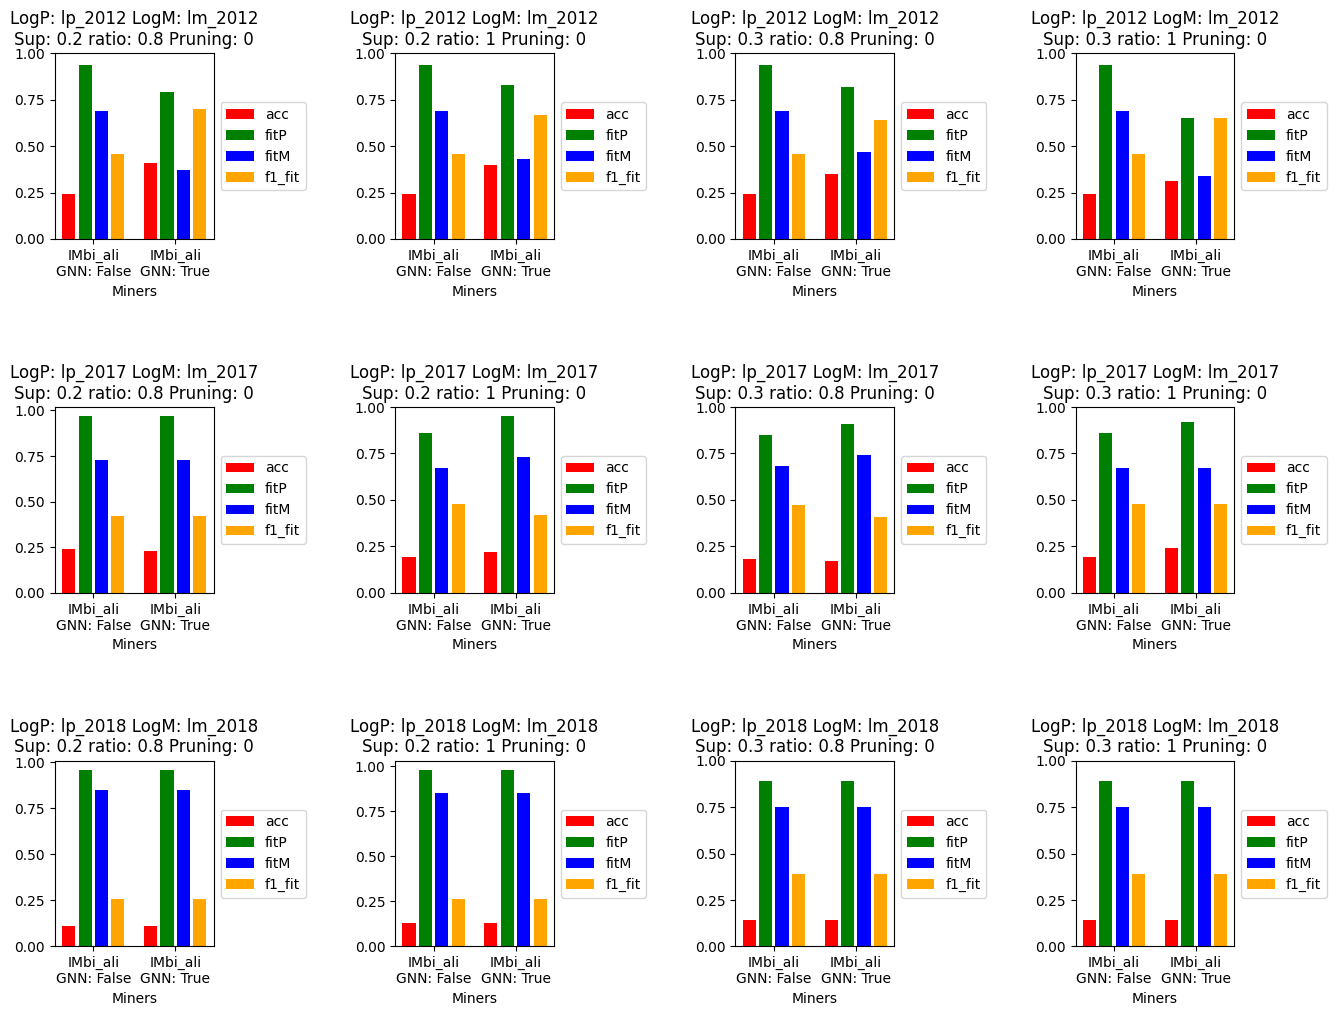

In [47]:
if analyse_gnn == False:
  if runSingleLog == False:
    displayDoubleLog(df)
  else:
    displaySingleLog(df)
else:
  displayDoubleLog(df)

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.2 Ratio: 1 GNN:False


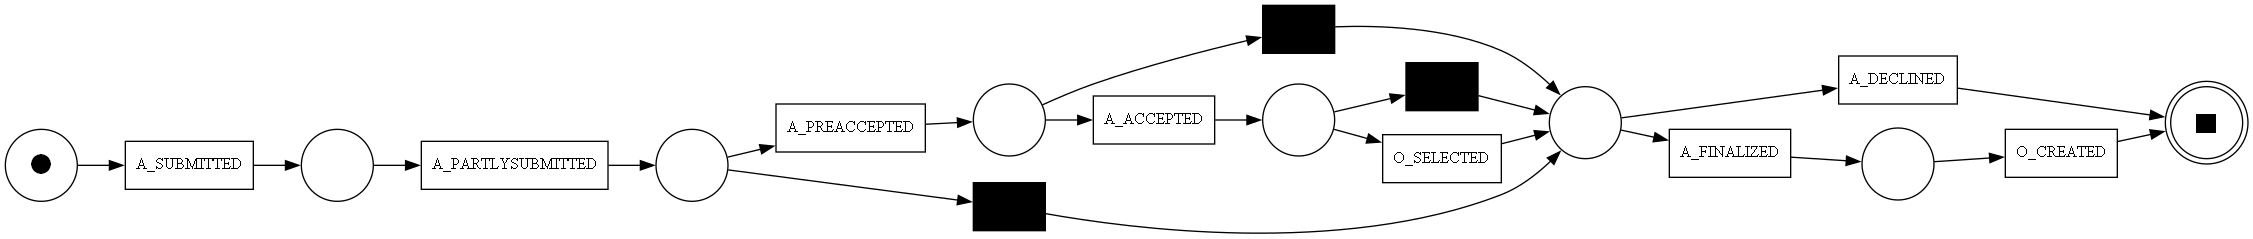

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.3 Ratio: 1 GNN:False


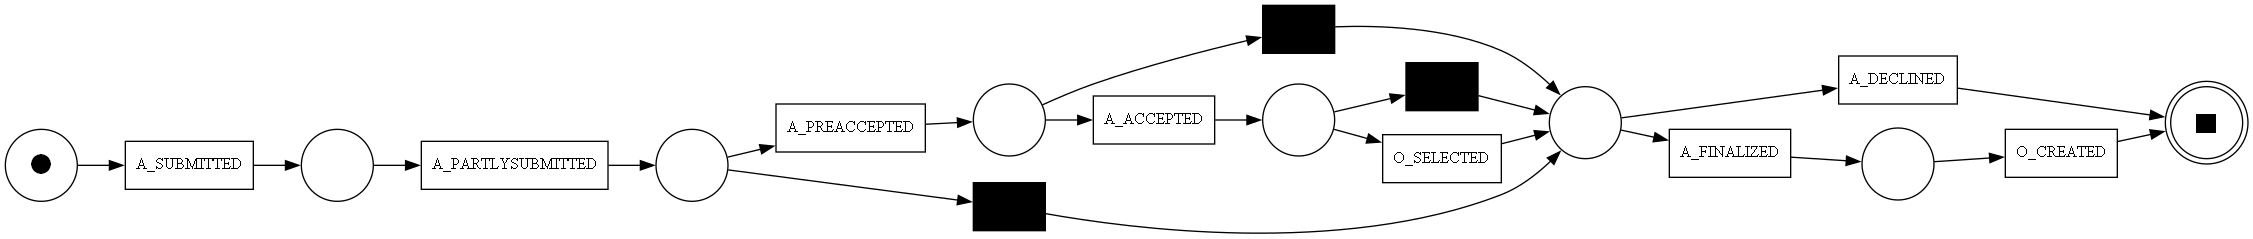

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.2 Ratio: 0.8 GNN:False


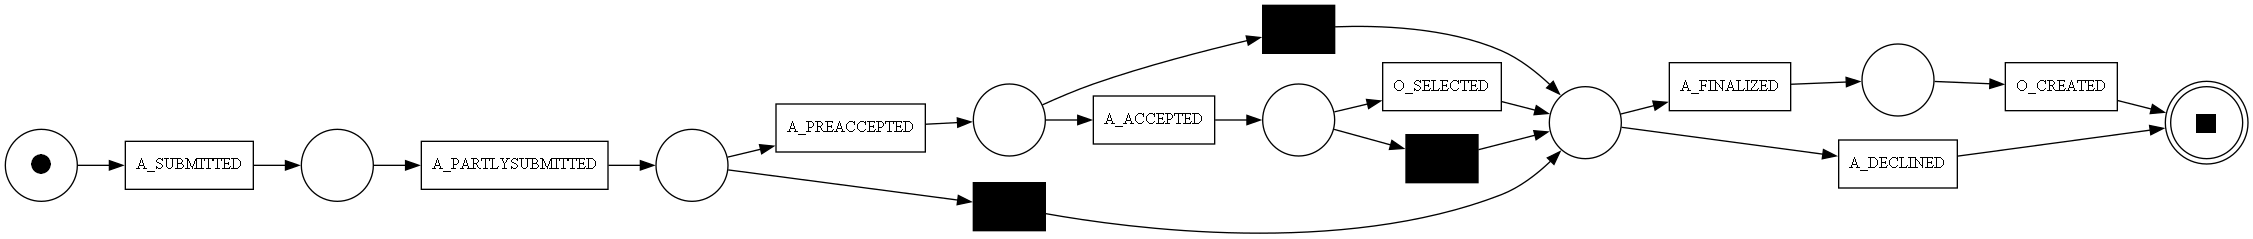

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.3 Ratio: 0.8 GNN:False


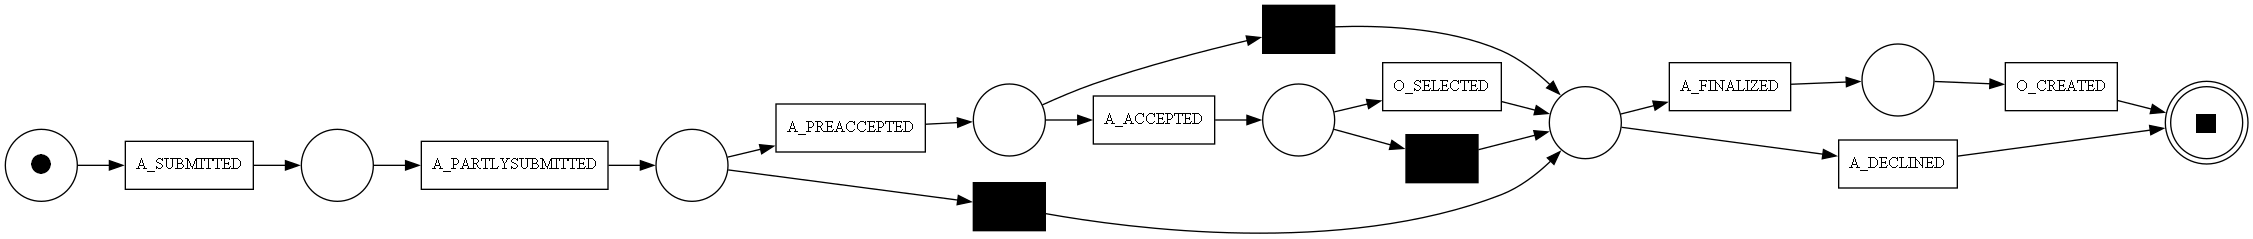

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.2 Ratio: 1 GNN:True


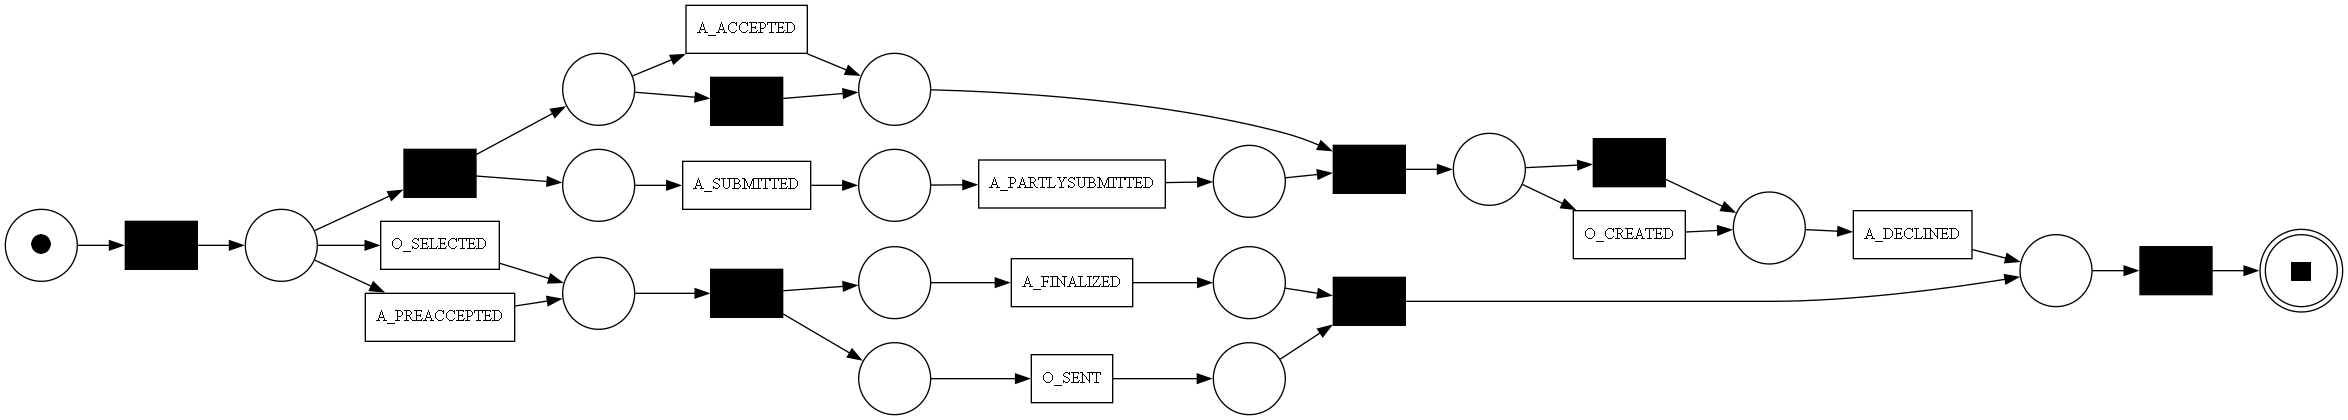

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.3 Ratio: 1 GNN:True


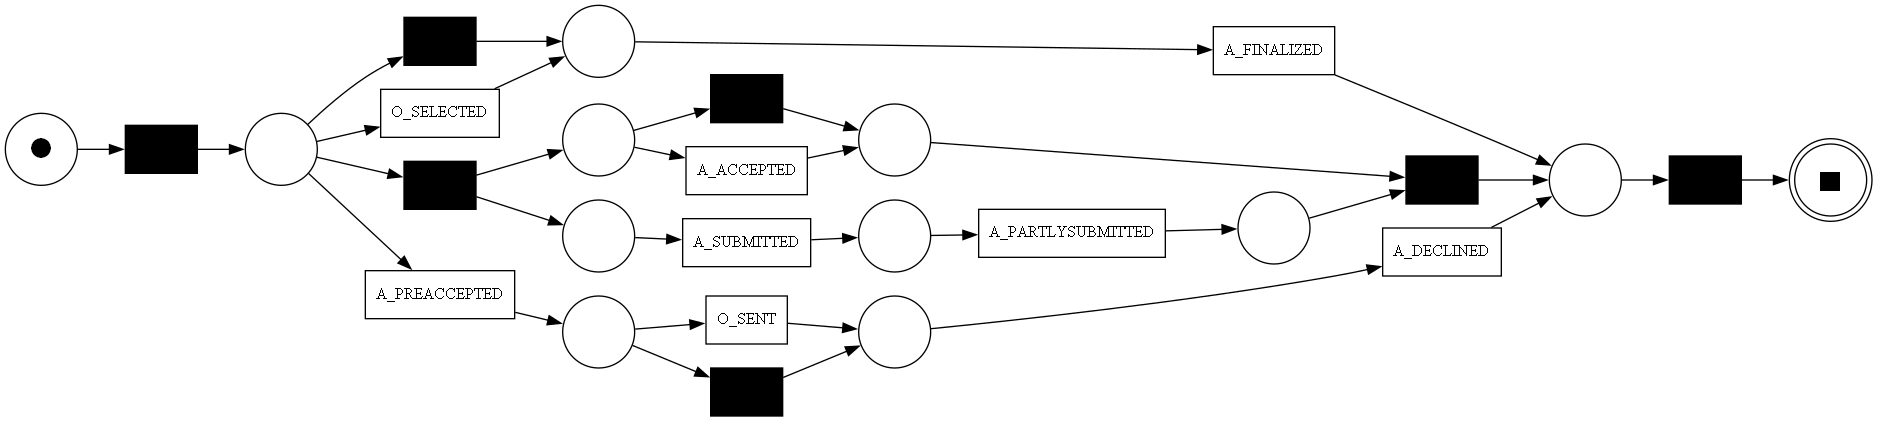

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.2 Ratio: 0.8 GNN:True


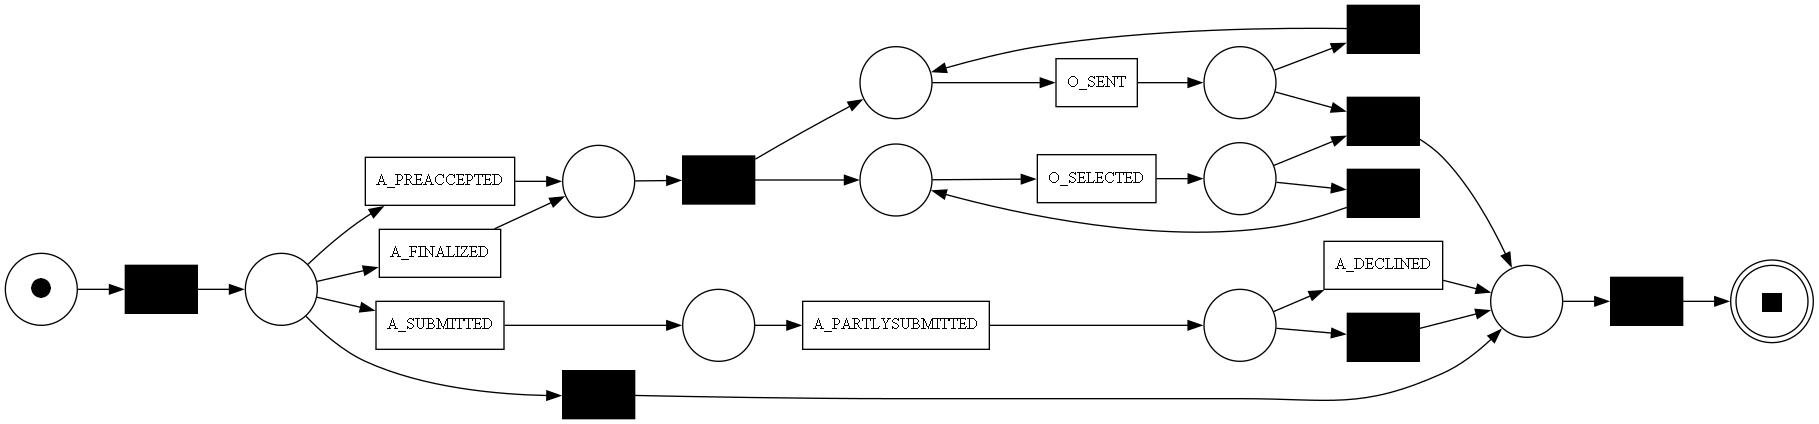

Displaying: IMbi_ali lp_2012 lm_2012 Sup: 0.3 Ratio: 0.8 GNN:True


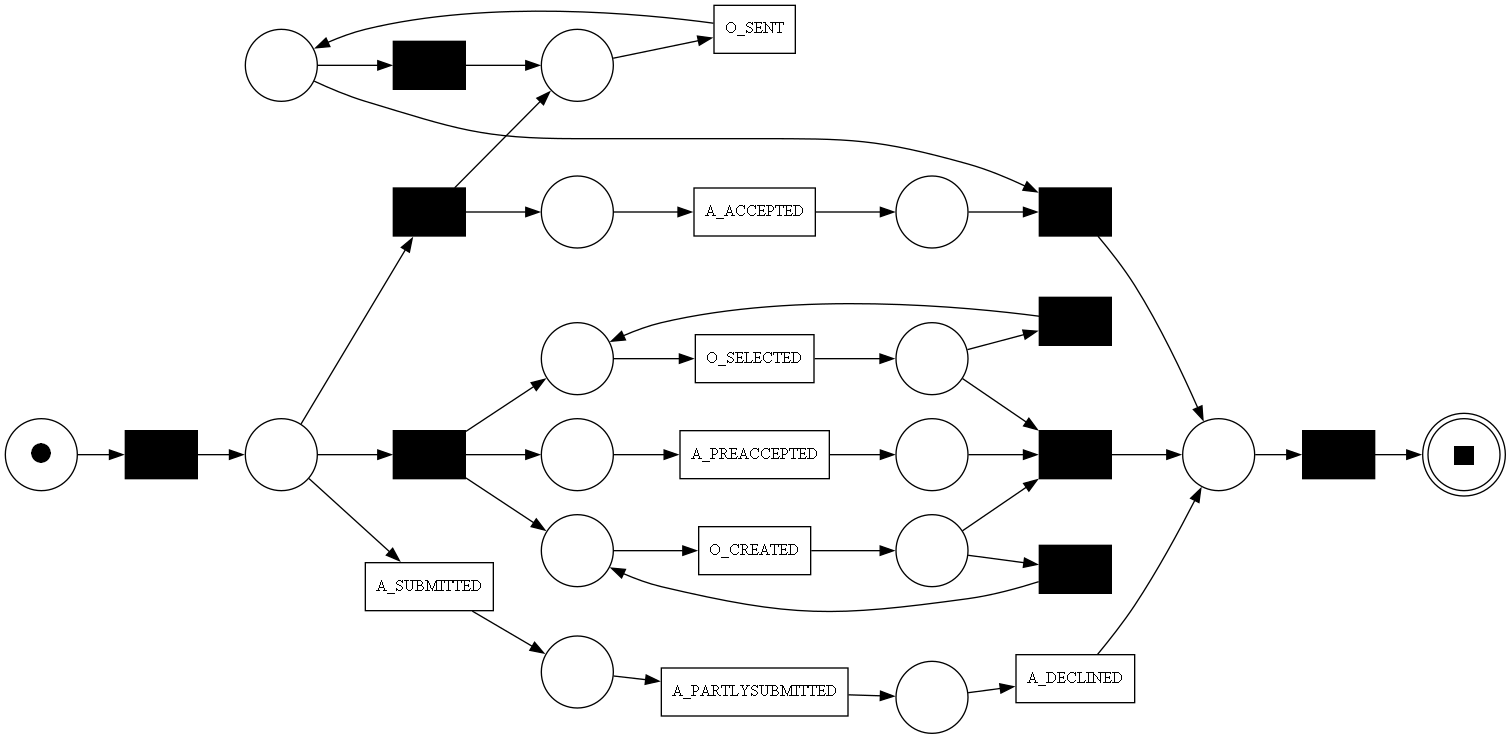

In [48]:
if True:
  if analyse_gnn == False:
    if runSingleLog == False:
      visualize_petriNet(df, "IM", "lp_2012.xes", "")
      visualize_petriNet(df, "IMbi_mar", "lp_2012", "lm_2012")
      visualize_petriNet(df, "IMbi_ali", "lp_2012", "lm_2012")
    else:
      visualize_petriNet(df, "IM", "lp_2012.xes", "")
      visualize_petriNet(df, "IMbi_mar", "lp_2012.xes", "")
      visualize_petriNet(df, "IMbi_ali", "lp_2012.xes", "")
  else:
    visualize_petriNet(df, "IMbi_ali", "lp_2012", "lm_2012", False)
    visualize_petriNet(df, "IMbi_ali", "lp_2012", "lm_2012", True)


In [49]:
if False:
  display(df)

from pm4py.objects.petri_net.exporter import exporter as pnml_exporter

net, im, fm = df.iloc[4].net, df.iloc[4].im, df.iloc[4].fm
view_petri_net(net, im, fm)
pnml_exporter.apply(net, im, "petri_IMbi.pnml", final_marking=fm)